# Generate mock PPDB/SSO data

* Generate 30 nights worth of DiaSources
  * 10M/night == 300M records
* Import mpc_orbits
* Generate the SSSource table
  * Asume about half of DiaSources are SSSources (concentrate them around the ecliptic)
  * Copy over the records from DiaSources
  * Fake the ephemerides using astrometry from DiaSources (add small shifts, 90% within .1 arcsec, the rest within 5", and .1 mag for magnitudes)
* Generate SSObject table
* Generate NearbySSO table
  * Copy all SSSources that have a match
  * Delete ~10% from the SSSource table, thise with match > .1arcsec; these will mimic the nearby-but-not-associated sources


In [1]:
import schema
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp

In [11]:
import numpy as np

def fill_zero_columns(arr):
    for name in arr.dtype.names:
        col = arr[name]

        # skip non-numeric fields
        if not np.issubdtype(col.dtype, np.number):
            continue

        # only fill columns that are zero everywhere
        if not np.all(col == 0):
            continue

        dt = col.dtype

        if np.issubdtype(dt, np.integer):
            col[:] = np.random.randint(0, 10000, size=len(col), dtype=dt)

        elif np.issubdtype(dt, np.floating):
            col[:] = np.random.standard_normal(len(col)).astype(dt)

        elif np.issubdtype(dt, np.bool_):
            col[:] = np.random.randint(0, 2, size=len(col)).astype(dt)

    return arr

def jitter_radec(ra, dec, r=1.0):
    ra, dec, tmax = map(np.deg2rad, (ra, dec, r))
    th = np.arccos(np.random.uniform(np.cos(tmax), 1.0, ra.size))
    ph = np.random.uniform(0.0, 2*np.pi, ra.size)
    sd, cd, sth, cth = np.sin(dec), np.cos(dec), np.sin(th), np.cos(th)
    dec = np.arcsin(sd*cth + cd*sth*np.cos(ph))
    ra  = (ra + np.arctan2(sth*np.sin(ph), cd*cth - sd*sth*np.cos(ph))) % (2*np.pi)
    return np.rad2deg(ra), np.rad2deg(dec), np.rad2deg(th)

import astropy.units as u
from astropy.coordinates import SkyCoord

def radec_to_galactic(ra, dec):
    c = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame="icrs")
    g = c.galactic
    return g.l.to_value(u.deg), g.b.to_value(u.deg)

def radec_to_ecl_iau76(ra, dec):
    ra, dec = np.deg2rad(ra), np.deg2rad(dec)
    ce, se = np.cos(np.deg2rad(84381.448/3600)), np.sin(np.deg2rad(84381.448/3600))
    x = np.cos(dec)*np.cos(ra)
    y = np.cos(dec)*np.sin(ra)
    z = np.sin(dec)
    lam = (np.rad2deg(np.arctan2(y*ce+z*se, x)) + 360) % 360
    bet = np.rad2deg(np.arcsin(-y*se+z*ce))
    return lam, bet



In [3]:
import numpy as np

def memmap_empty(path, shape, dtype, order="C"):
    """
    Create a file-backed, uninitialized ndarray (np.empty analog).

    Parameters
    ----------
    path : str or Path
        File path backing the memmap.
    shape : int or tuple of int
        Array shape.
    dtype : numpy dtype or dtype spec
        Array dtype.
    order : {"C", "F"}, optional
        Memory layout.

    Returns
    -------
    ndarray
        File-backed NumPy array.
    """
    mm = np.memmap(
        path,
        dtype=np.dtype(dtype),
        mode="w+",
        shape=shape,
        order=order,
    )
    return np.asarray(mm)

In [64]:
import numpy as np

def structured_to_parquet(dia, path, *, batch_rows=1_000_000, compression="zstd",
                          use_dictionary=True, write_statistics=True):
    """
    Serialize a structured numpy array (possibly memmap) to a Parquet file in chunks.

    Parameters
    ----------
    dia : np.ndarray
        Structured array with dtype.names. Can be np.memmap.
    path : str | pathlib.Path
        Output parquet path.
    batch_rows : int
        Rows per write batch (and default row group size).
    compression : str | None
        Parquet compression (e.g., "zstd", "snappy", "gzip", None).
    use_dictionary : bool
        Enable dictionary encoding where beneficial.
    write_statistics : bool
        Write column statistics (can improve predicate pushdown; may add overhead).
    """
    import pyarrow as pa
    import pyarrow.parquet as pq

    if dia.dtype.names is None:
        raise TypeError("dia must be a structured array (dia.dtype.names is None).")

    n = len(dia)
    if n == 0:
        # Write an empty file with the right schema.
        arrays = [pa.array(dia[name]) for name in dia.dtype.names]
        table = pa.Table.from_arrays(arrays, names=list(dia.dtype.names))
        pq.write_table(table, path, compression=compression,
                       use_dictionary=use_dictionary, write_statistics=write_statistics)
        return

    writer = None
    try:
        for start in range(0, n, batch_rows):
            stop = min(start + batch_rows, n)
            chunk = dia[start:stop]  # works for memmap without loading everything

            arrays = [pa.array(chunk[name]) for name in chunk.dtype.names]
            table = pa.Table.from_arrays(arrays, names=list(chunk.dtype.names))

            if writer is None:
                writer = pq.ParquetWriter(
                    path, table.schema,
                    compression=compression,
                    use_dictionary=use_dictionary,
                    write_statistics=write_statistics,
                )

            writer.write_table(table, row_group_size=len(chunk))
    finally:
        if writer is not None:
            writer.close()


In [4]:
mjd0 = 61041 # Jan 1, 2026
nnights = 3
visitsPerNight = 1000
diaPerVisit = 1_000
diaPerNight = diaPerVisit * visitsPerNight

ndia = diaPerNight*nnights

# DiaSource

In [5]:
#dia = memmap_empty("diasource.dat", shape=(ndia,), dtype=schema.DiaSourceDtype)
dia = np.empty(shape=(ndia,), dtype=schema.DiaSourceDtype)

In [6]:
dia["midpointMjdTai"] = np.random.uniform(mjd0, mjd0 + nnights, ndia)
dia["midpointMjdTai"].sort()
dia["midpointMjdTai"] -= (dia["midpointMjdTai"] - dia["midpointMjdTai"].astype(int)) / 2.

dia["diaSourceId"] = np.arange(ndia)
dia["visit"] = dia["diaSourceId"] / diaPerVisit
vis_det = dia["visit"] * 1000 + dia["diaSourceId"] % 189
vis_det.sort()
vis_det -= dia["visit"] * 1000
dia["detector"] = vis_det

dia["diaObjectId"] = dia["diaSourceId"] / nnights

dia["ra"] = np.random.uniform(0, 360, size=len(dia))
dia["raErr"] = np.random.uniform(0, 0.2, size=len(dia))
dia["dec"] = np.random.uniform(-90, 90, size=len(dia))
dia["decErr"] = np.random.uniform(0, 0.2, size=len(dia))

ra, dec = hp.pix2ang(16, 3*(dia["visit"] % visitsPerNight), nest=True, lonlat=True)
ra, dec, _ = jitter_radec(ra, dec, 1.6)
dia["ra"], dia["dec"] = ra, dec

dia["apFlux"] = np.random.uniform(3.63, 912, size=len(dia)) # (15 .. 24th mag flux)
dia["apFluxErr"] = np.random.uniform(0.1, 0.6, size=len(dia))
dia["psfFlux"] = dia["apFlux"] + np.random.uniform(-0.5, 0.5, size=len(dia))
dia["psfFluxErr"] = dia["apFluxErr"] + np.random.uniform(-0.1, 0.1, size=len(dia))

pd.DataFrame(dia[998:][:10])

,diaSourceId,visit,detector,diaObjectId,parentDiaSourceId,ssObjectReassocTimeMjdTai,midpointMjdTai,ra,raErr,dec,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail
0,998,0,188,332,0,0.0,61041.000511,46.013791,0.130410,1.397816,...,False,False,False,False,False,False,False,False,False,False
1,999,0,188,333,0,0.0,61041.000511,44.429633,0.091823,2.369535,...,False,False,False,False,False,False,False,False,False,False
2,1000,1,0,333,0,0.0,61041.000512,44.506725,0.045034,8.327435,...,False,False,False,False,False,False,False,False,False,False
3,1001,1,0,333,0,0.0,61041.000512,44.319251,0.164921,8.488331,...,False,False,False,False,False,False,False,False,False,False
4,1002,1,0,334,0,0.0,61041.000512,43.608149,0.198728,7.048832,...,False,False,False,False,False,False,False,False,False,False
5,1003,1,0,334,0,0.0,61041.000513,45.752207,0.002588,7.659968,...,False,False,False,False,False,False,False,False,False,False
6,1004,1,0,334,0,0.0,61041.000513,43.612492,0.149675,7.942188,...,False,False,False,False,False,False,False,False,False,False
7,1005,1,1,335,0,0.0,61041.000514,46.339009,0.078420,6.903879,...,False,False,False,False,False,False,False,False,False,False
8,1006,1,1,335,0,0.0,61041.000515,45.813190,0.032530,7.222413,...,False,False,False,False,False,False,False,False,False,False
9,1007,1,1,335,0,0.0,61041.000515,46.120459,0.138357,6.485726,...,False,False,False,False,False,False,False,False,False,False


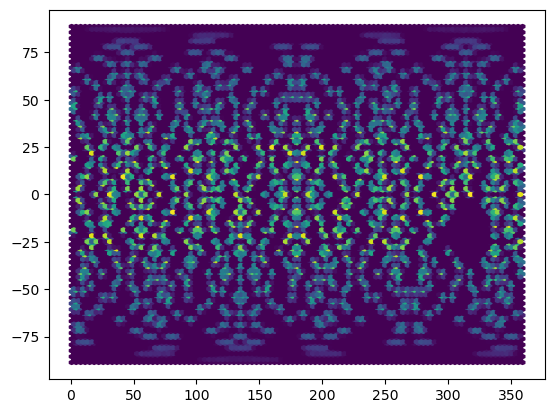

In [7]:
plt.hexbin(dia["ra"], dia["dec"]);

# mpc_orbits

In [8]:
mpc = pd.read_parquet("mpc_orbits.parquet", columns=["unpacked_primary_provisional_designation"])
nmpc = len(mpc)

# SSObject

In [9]:
# random subset
np.random.seed(42)
idx = np.random.permutation(nmpc)[:int(0.7*nmpc)]

ssobject = np.empty(shape=(len(idx),), dtype=schema.SSObjectDtype)
ssobject["ssObjectId"] = idx
ssobject["designation"] = mpc["unpacked_primary_provisional_designation"][idx]

# fill unfilled columns with junk
fill_zero_columns(ssobject)

print(len(ssobject))
pd.DataFrame(ssobject[:10])

1032644


,ssObjectId,designation,nObs,arc,firstObservationMjdTai,MOIDEarth,MOIDEarthDeltaV,MOIDEarthEclipticLongitude,MOIDEarthTrueAnomaly,MOIDEarthTrueAnomalyObject,...,y_H,y_HErr,y_G12,y_G12Err,y_H_y_G12_Cov,y_nObsUsed,y_Chi2,y_phaseAngleMin,y_phaseAngleMax,y_slope_fit_failed
0,311760,2015 VG32,2374,-1.478631,-0.292306,0.647577,-0.495764,-0.611697,1.380248,-1.340388,...,0.115076,0.990207,0.485250,0.780864,-0.170666,6887,-0.149353,-2.289966,-1.244674,False
1,1281749,2022 YQ1,1217,-0.796422,-0.243847,-1.088080,0.583837,0.651035,-0.856208,0.921564,...,-1.099212,-1.069216,0.489205,0.812728,-0.412753,4040,0.766732,0.034044,-0.469727,False
2,845962,2015 HW36,7920,0.338510,2.397650,-0.517634,0.283574,-0.348210,-0.827649,1.148490,...,0.083686,-0.140941,1.711507,1.714667,1.508654,4432,-0.752593,1.183778,-1.247834,False
3,589552,2021 NK68,2978,-0.586377,-0.265980,0.362273,2.389156,0.041165,0.212455,0.531824,...,-0.457661,-0.086430,0.828627,-0.073746,0.575777,6735,-1.303079,0.793984,-1.177323,False
4,608535,2008 PT17,3644,0.010412,2.276286,0.203592,-2.662896,-1.508017,0.854576,-0.042769,...,-0.023919,-0.110499,1.336411,0.698431,-1.876331,9616,1.150208,-0.131057,0.768031,False
5,293782,2007 RC158,7816,-0.717445,-0.035307,-2.026316,0.511939,1.038151,-0.553260,-0.614636,...,1.609919,-0.017067,2.598328,0.463770,1.052420,1515,-0.156274,0.191175,1.410089,False
6,280434,2006 VF130,512,-1.071363,-1.332954,1.907301,1.469960,-0.349418,0.888573,-0.899475,...,1.424309,2.386384,-1.982025,0.139603,0.601860,304,-0.573387,-0.295533,2.415644,False
7,511532,2014 UN303,3028,-1.184673,-0.877562,0.107923,-0.437785,0.051446,-1.063623,1.618796,...,2.999392,1.851990,1.832187,1.436780,-1.444221,5106,-0.487091,-0.907155,-1.261259,False
8,1013634,2003 FB119,4512,0.967993,0.860118,-0.360051,-0.543004,-0.562103,1.126706,-0.303662,...,-0.290358,1.905971,-0.226427,0.326954,-0.155981,2174,0.145368,0.863325,-0.165092,False
9,1137014,2020 PZ59,5020,1.243985,-0.099793,-0.089560,-0.462025,-1.440770,-1.909268,0.397979,...,-0.357992,0.917969,-2.214868,-0.077979,-0.505839,6740,-0.109657,-0.342641,1.219262,False


# SSSource

In [57]:
# select a band around the ecliptic
def gaussian_beta_mask(beta, sigma, frac=0.5):
    beta = np.asarray(beta, dtype=np.float64)
    n = beta.size

    w = np.exp(-0.5 * (beta / sigma)**2)        # Gaussian weights
    u = np.random.random(n)
    keys = -np.log(u) / w                       # weighted sampling keys

    k = int(round(frac * n))
    sel = np.argpartition(keys, k-1)[:k]

    mask = np.zeros(n, dtype=bool)
    mask[sel] = True
    return mask

_, beta = radec_to_ecl_iau76(dia["ra"], dia["dec"])
mask = gaussian_beta_mask(beta, sigma=10.0, frac=0.55)
mask = np.nonzero(mask)[0]
n = int(0.5*len(dia))
mask_extra = mask[n:]
mask = mask[:n]

# copy only those Dia records into SSSource
sssource = np.empty(shape=(n,), dtype=schema.SSSourceDtype)
for col in dia.dtype.names:
    if col not in ["diaObjectId", "ssObjectReassocTimeMjdTai", "timeWithdrawnMjdTai"]:
        sssource[col] = dia[col][mask]

# choose the designations we'll link to
ndesig = np.random.randint(0, len(ssobject), size=1_000)

def fill_sssource(sssource, ndesig, ra, dec, r):
    # fake ephemerides, within 1" of the true observation
    ephRa, ephDec, dist = jitter_radec(ra, dec, r/3600)
    dist *= 3600

    # assign designations
    idx = ndesig[sssource["diaSourceId"] % len(ndesig)]
    sssource["ssObjectId"] = ssobject["ssObjectId"][idx]
    sssource["designation"] = ssobject["designation"][idx]
    
    sssource["ephRa"], sssource["ephDec"], sssource["ephOffset"] = ephRa, ephDec, dist

# compute columns
ra, dec = dia["ra"][mask], dia["dec"][mask]
sssource["eclLambda"], sssource["eclBeta"] = radec_to_ecl_iau76(ra, dec)
sssource["galLon"], sssource["galLat"] = radec_to_galactic(ra, dec)

# fill the values
fill_sssource(sssource, ndesig, ra, dec, r=1)

fill_zero_columns(sssource)

print(len(sssource))
pd.DataFrame(sssource[:10])

1500000


,diaSourceId,ssObjectId,designation,eclLambda,eclBeta,galLon,galLat,elongation,phaseAngle,topoRange,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,glint_trail
0,0,274773,2006 CG34,42.173545,-14.353709,174.065409,-48.283095,-1.131775,-0.329659,-0.337190,...,False,False,False,False,False,False,False,False,False,False
1,1,1345956,2013 RT23,41.944065,-14.048704,173.502036,-48.328905,-0.596754,-0.133167,0.823914,...,False,False,False,False,False,False,False,False,False,False
2,2,510482,2016 TB98,42.955314,-15.573259,176.215198,-48.195087,-0.685098,-1.022172,0.651663,...,False,False,False,False,False,False,False,False,False,False
3,3,1360487,2001 DT4,43.199155,-13.841258,174.117789,-47.164690,-1.852878,0.509670,-0.511373,...,False,False,False,False,False,False,False,False,False,False
4,4,323644,2010 TN214,42.666855,-14.376067,174.440141,-47.875421,-0.041617,-0.702718,-0.309163,...,False,False,False,False,False,False,False,False,False,False
5,5,175202,2009 KF33,42.417878,-13.572718,173.221124,-47.694119,0.274682,-1.165474,0.108679,...,False,False,False,False,False,False,False,False,False,False
6,6,391017,2011 BF7,42.948628,-13.083373,172.973096,-47.002785,0.407244,-0.700447,0.303758,...,False,False,False,False,False,False,False,False,False,False
7,7,827433,2004 XV92,42.384356,-13.269642,172.806768,-47.571841,-2.363589,0.234384,0.566161,...,False,False,False,False,False,False,False,False,False,False
8,8,933694,2015 ME88,42.048020,-14.426501,174.072747,-48.424721,-2.438590,0.456333,-2.717573,...,False,False,False,False,False,False,False,False,False,False
9,9,431025,2015 HM465,43.116766,-14.109042,174.405544,-47.364612,-0.336899,-0.391746,1.950979,...,False,False,False,False,False,False,False,False,False,False


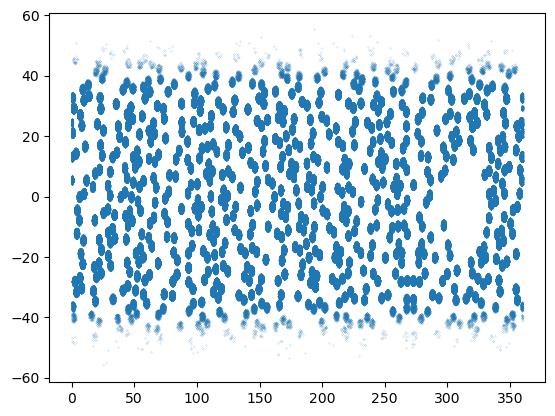

In [58]:
plt.scatter(sssource["eclLambda"], sssource["eclBeta"], s=0.01)

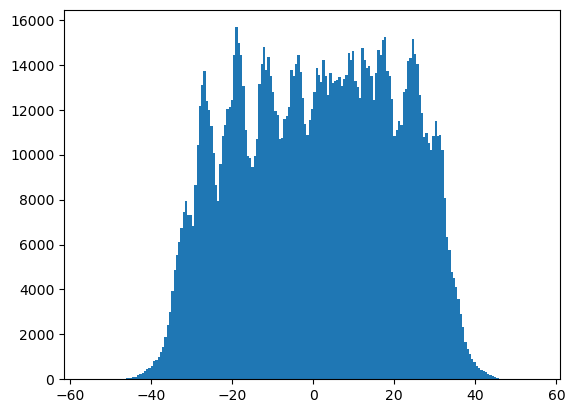

In [59]:
plt.hist(sssource["eclBeta"], bins='fd');

# NearbySSO

In [63]:
n = len(sssource)
near = np.empty(shape=(n + len(mask_extra),), dtype=schema.NearbySSODtype)

near["diaSourceId"][:n] = sssource["diaSourceId"]
near["ssObjectId"][:n] = sssource["ssObjectId"]
near["designation"][:n] = sssource["designation"]
near["ephRa"][:n] = sssource["ephRa"]
near["ephDec"][:n] = sssource["ephDec"]
near["ephOffset"][:n] = sssource["ephOffset"]
near["ephVmag"][:n] = sssource["ephVmag"]
near["ephRateRa"][:n] = sssource["ephRateRa"]
near["ephRateDec"][:n] = sssource["ephRateDec"]

# fill the values for the "nearby" (and not associated) objects
ra, dec = dia["ra"][mask_extra], dia["dec"][mask_extra]
near["diaSourceId"][n:] = dia["diaSourceId"][mask_extra]
fill_sssource(near[n:], ndesig, ra, dec, r=5)
fill_zero_columns(near[n:])

print(len(near))
pd.DataFrame(near[n-5:n+5])

1650000


,diaSourceId,ssObjectId,designation,ephRa,ephDec,ephOffset,ephVmag,ephRateRa,ephRateDec
0,2626241,1420721,2005 EZ82,306.725306,0.391817,0.890200,-0.573584,0.112599,-1.063198
1,2626242,1406864,2012 GD8,307.461632,-0.819532,0.784252,1.982306,1.381704,-0.073858
2,2626243,1347858,2024 SB10,305.873139,1.246238,0.848259,-0.501913,-0.271363,-0.996838
3,2626244,990640,2016 EA358,307.938495,0.060018,0.976273,-0.666799,1.668963,0.018189
4,2626245,424805,2020 HH119,307.206477,-1.403375,0.752533,0.195653,-0.246608,1.607178
5,2626246,214636,2017 QS92,305.731152,0.209987,3.241271,-0.156080,0.148650,0.653899
6,2626247,398548,2008 GQ156,305.523458,-0.233661,4.869277,-0.650553,-0.250248,0.293213
7,2626248,269055,2015 AS177,306.309127,1.335530,4.616635,-0.306608,0.473159,-0.193284
8,2626249,683442,2015 VN217,306.066433,0.066704,3.072034,-1.072030,-0.278973,-0.028958
9,2626250,64773,2005 LS17,307.136210,-0.734199,3.570999,-0.314364,-1.045206,-0.131186


# Write out the results

In [68]:
structured_to_parquet(dia,      "diasource.parquet")
structured_to_parquet(sssource, "sssource.parquet")
structured_to_parquet(ssobject, "ssobject.parquet")
structured_to_parquet(near,     "nearbysso.parquet")